In [3]:
%matplotlib inline

__Note:__ I wrote this post in an IPython notebook. It might be rendered better [on NBViewer](http://nbviewer.ipython.org/github/tdhopper/stigler-diet/blob/master/content/articles/2015-07-28-dirichlet-distribution-dirichlet-process.ipynb). 

## Dirichlet Distribution

The symmetric [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution) (DD) can be considered a distribution of distributions. Each sample from the DD is a [categorial distribution](https://en.wikipedia.org/wiki/Categorical_distribution) over $K$ categories. It is parameterized $G_0$, a distribution over $K$ categories and $\alpha$, a scale factor.

The expected value of the DD is $G_0$. The variance of the DD is a function of the scale factor. When $\alpha$ is large, samples from $DD(\alpha\cdot G_0)$ will be very close to $G_0$. When $\alpha$ is small, samples will vary more widely. 

We demonstrate below by setting $G_0=[.2, .2, .6]$ and varying $\alpha$ from 0.1 to 1000. In each case, the mean of the samples is roughly $G_0$, but the standard deviation is decreases as $\alpha$ increases.

In [10]:
import numpy as np
from scipy.stats import dirichlet
np.set_printoptions(precision=2)

def stats(scale_factor, G0=[.2, .2, .6], N=10000):
    samples = dirichlet(alpha = scale_factor * np.array(G0)).rvs(N)
    print "                          alpha:", scale_factor
    print "              element-wise mean:", samples.mean(axis=0)
    print "element-wise standard deviation:", samples.std(axis=0)
    print
    
for scale in [0.1, 1, 10, 100, 1000]:
    stats(scale)

                          alpha: 0.1
              element-wise mean: [ 0.2  0.2  0.6]
element-wise standard deviation: [ 0.38  0.38  0.47]

                          alpha: 1
              element-wise mean: [ 0.2  0.2  0.6]
element-wise standard deviation: [ 0.28  0.28  0.35]

                          alpha: 10
              element-wise mean: [ 0.2  0.2  0.6]
element-wise standard deviation: [ 0.12  0.12  0.15]

                          alpha: 100
              element-wise mean: [ 0.2  0.2  0.6]
element-wise standard deviation: [ 0.04  0.04  0.05]

                          alpha: 1000
              element-wise mean: [ 0.2  0.2  0.6]
element-wise standard deviation: [ 0.01  0.01  0.02]



## Dirichlet Process

The [Dirichlet Process](https://en.wikipedia.org/wiki/Dirichlet_process) can be considered a way to _generalize_ the Dirichlet distribution. While the Dirichlet distribution is parameterized by a discrete distribution $G_0$ and generates samples that are similar discrete distributions, the Dirichlet process is parameterized by a generic distribution $H_0$ and generates samples which are distributions similar to $H_0$. The Dirichlet process also has a parameter $\alpha$ that determines how similar how widely samples will vary from $H_0$.

We can construct a sample $H$ (recall that $H$ is a probability distribution) from a Dirichlet process $\text{DP}(\alpha H_0)$ by drawing a countably infinite number of samples $\theta_k$ from $H_0$) and setting:

$$H=\sum_{k=1}^\infty \pi_k \cdot\delta(x-\theta_k)$$

where the $\pi_k$ are carefully chosen weights (more later) that sum to 1. ($\delta$ is the [Dirac delta function](https://en.wikipedia.org/wiki/Dirac_delta_function).)

$H$, a sample from $DP(\alpha H_0)$, is a _probability distribution_ that looks similar to $H_0$ (also a distribution). In particular, $H$ is a _discrete_ distribution that takes the value $\theta_k$ with probability $\pi_k$. This sampled distribution $H$ is a discrete distribution _even if $H_0$ has continuous support_; the [support](http://www.statlect.com/glossary/support_of_a_random_variable.htm) of $H$ is a countably infinite subset of the support $H_0$.

The weights ($\pi_k$ values) of a Dirichlet process sample related the Dirichlet _process_ back to the Dirichlet _distribution_. 

[Gregor Heinrich](http://www.arbylon.net/publications/ilda.pdf) writes:

> The defining property of the DP is that its samples have weights $\pi_k$ and locations $\theta_k$ distributed in such a way that when partitioning $S(H)$ into finitely many arbitrary disjoint subsets $S_1, \ldots, S_j$ $J<\infty$, the sums of the weights $\pi_k$ in each of these $J$ subsets are distributed according to a Dirichlet distribution that is parameterized by $\alpha$ and a discrete base distribution (like $G_0$) whose weights are equal to the integrals of the base distribution $H_0$ over the subsets $S_n$.

As an example, Heinrich imagines a DP with a standard normal base measure $H_0\sim \mathcal{N}(0,1)$. Let $H$ be a sample from $DP(H_0)$ and partition the real line (the support of a normal distribution) as $S_1=(-\infty, -1]$, $S_2=(-1, 1]$, and $S_3=(1, \infty]$ then

$$H(S_1),H(S_2), H(S_3) \sim \text{Dir}\left(\alpha\,\text{erf}(-1), \alpha\,(\text{erf}(1) - \text{erf}(-1)), \alpha\,(1-\text{erf}(1))\right)$$

where $H(S_n)$ be the sum of the $\pi_k$ values whose $\theta_k$ lie in $S_n$. 

These $S_n$ subsets are chosen for convenience, however similar results would hold for _any_ choice of $S_n$. For any sample from a Dirichlet _process_, we can construct a sample from a Dirichlet _distribution_ by partitioning the support of the sample into a finite number of bins.

There are several equivalent ways to choose the $\pi_k$ so that this property is satisfied: the Chinese restaurant process, the stick-breaking process, and the Pólya urn scheme. 

To generate $\left\{\pi_k\right\}$ according to a stick-breaking process we define $\beta_k$ to be a sample from $\text{Beta}(1,\alpha)$. $\pi_1$ is equal to $\beta_1$. Successive values are defined recursively as

$$\pi_k=\beta_k \prod_{j=1}^{k-1}(1-\beta_j).$$

Thus, if we want to draw a sample from a Dirichlet process, we could, in theory, sample an infinite number of $\theta_k$ values from the base distribution $H_0$, an infinite number of $\beta_k$ values from the Beta distribution. Of course, sampling an infinite number of values is easier in theory than in practice.

However, by noting that the $\pi_k$ values are _positive_ values summing to 1, we note that, in expectation, they must get increasingly small as $k\rightarrow\infty$. Thus, we can reasonably approximate a sample $H\sim DP(\alpha H_0)$ by drawing _enough_ samples such that $\sum_{k=1}^K \pi_k\approx 1$.

We use this method below to draw approximate samples from several Dirichlet processes with a standard normal ($\mathcal{N}(0,1)$) base distribution but varying $\alpha$ values.

Recall that a single sample from a Dirichlet process is a probability distribution over a countably infinite subset of the support of the base measure. 

The blue line is the PDF for a standard normal. The black lines represent the $\theta_k$ and $\pi_k$ values; $\theta_k$ is indicated by the position of the black line on the $x$-axis; $\pi_k$ is proportional to the height of each line. 

We generate enough $\pi_k$ values are generated so their sum is greater than 0.99. When $\alpha$ is small, very few $\theta_k$'s will have corresponding $\pi_k$ values larger than $0.01$. However, as $\alpha$ grows large, the sample becomes a more accurate (though still discrete) approximation of $\mathcal{N}(0,1)$.

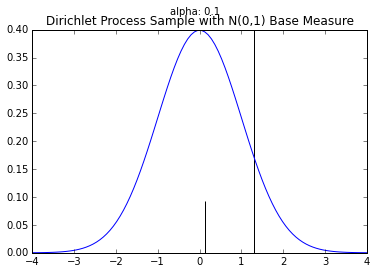

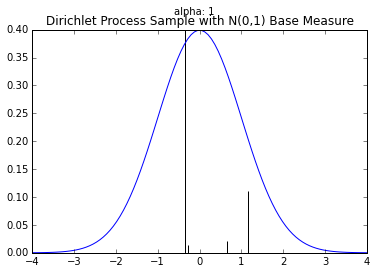

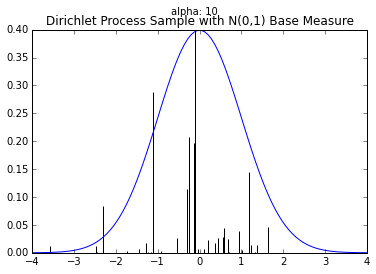

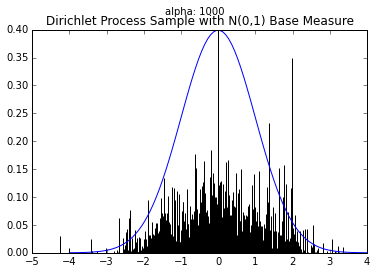

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import beta, norm

def dirichlet_sample_approximation(base_measure, alpha, tol=0.01):
    betas = []
    pis = []
    betas.append(beta(1, alpha).rvs())
    pis.append(betas[0])
    while sum(pis) < (1.-tol):
        s = np.sum([np.log(1 - b) for b in betas])
        new_beta = beta(1, alpha).rvs() 
        betas.append(new_beta)
        pis.append(new_beta * np.exp(s))
    pis = np.array(pis)
    thetas = np.array([base_measure() for _ in pis])
    return pis, thetas

def plot_normal_dp_approximation(alpha):
    plt.figure()
    plt.title("Dirichlet Process Sample with N(0,1) Base Measure")
    plt.suptitle("alpha: %s" % alpha)
    pis, thetas = dirichlet_sample_approximation(lambda: norm().rvs(), alpha)
    pis = pis * (norm.pdf(0) / pis.max())
    plt.vlines(thetas, 0, pis, )
    X = np.linspace(-4,4,100)
    plt.plot(X, norm.pdf(X))

plot_normal_dp_approximation(.1)
plot_normal_dp_approximation(1)
plot_normal_dp_approximation(10)
plot_normal_dp_approximation(1000)

Often we want to draw samples from a _distribution sampled from a Dirichlet process_ instead of from the Dirichlet process itself. Much of the literature on the topic unhelpful refers to this as sampling from a Dirichlet process. 

Fortunately, we don't have to draw an infinite number of samples from the base distribution and stick breaking process to do this. Instead, we can draw these samples _as they are needed_. 

Suppose, for example, we know a finite number of the $\theta_k$ and $\pi_k$ values for a sample $H\sim \text{Dir}(\alpha H_0)$. For example, we know

$$\pi_1=0.5,\; \pi_3=0.3,\; \theta_1=0.1,\; \theta_2=-0.5.$$

To sample from $H$, we can generate a uniform random $u$ number between 0 and 1. If $u$ is less than 0.5, our sample is $0.1$. If $0.5<=u<0.8$, our sample is $-0.5$. If $u>=0.8$, our sample (from $H$ will be a new sample $\theta_3$ from $H_0$. At the same time, we should also sample and store $\pi_3$. When we draw our next sample, we will again draw $u\sim\text{Uniform}(0,1)$ but will compare against $\pi_1, \pi_2$, AND $\pi_3$.

The class below will take a base distribution $H_0$ and $\alpha$ as arguments to its constructor. The class instance can then be called to generate samples from $H\sim \text{DP}(\alpha H_0)$.

In [20]:
from numpy.random import choice

class DirichletProcessSample():
    def __init__(self, base_measure, alpha):
        self.base_measure = base_measure
        self.alpha = alpha
        
        self.cache = []
        self.weights = []
        self.total_stick_used = 0.

    def __call__(self):
        remaining = 1.0 - self.total_stick_used
        i = DirichletProcessSample.roll_die(self.weights + [remaining])
        if i is not None and i < len(self.weights) :
            return self.cache[i]
        else:
            stick_piece = beta(1, self.alpha).rvs() * remaining
            self.total_stick_used += stick_piece
            self.weights.append(stick_piece)
            new_value = self.base_measure()
            self.cache.append(new_value)
            return new_value
        
    @staticmethod 
    def roll_die(weights):
        if weights:
            return choice(range(len(weights)), p=weights)
        else:
            return None

This Dirichlet process class could be called _stochastic memoization_. This idea was first articulated in somewhat abstruse terms by [Daniel Roy, et al](http://danroy.org/papers/RoyManGooTen-ICMLNPB-2008.pdf).

Below are histograms of 10000 samples drawn from _samples_ drawn from Dirichlet processes with standard normal base distribution and varying $\alpha$ values. 

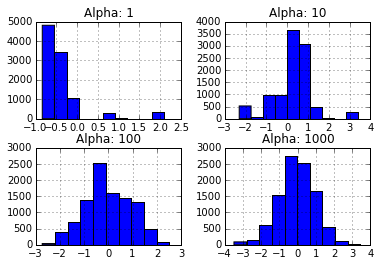

In [22]:
import pandas as pd

base_measure = lambda: norm().rvs()
n_samples = 10000
samples = {}
for alpha in [1, 10, 100, 1000]:
    dirichlet_norm = DirichletProcessSample(base_measure=base_measure, alpha=alpha)
    samples["Alpha: %s" % alpha] = [dirichlet_norm() for _ in range(n_samples)]

_ = pd.DataFrame(samples).hist()

Note that these histograms look very similar to the corresponding plots of sampled distributions above. However, these histograms are plotting _points sampled from a distribution sampled from a Dirichlet process_ while the plots above were showing approximate _distributions samples from the Dirichlet process_. Of course, as the number of samples from each $H$ grows large, we would expect the histogram to be a very good empirical approximation of $H$.

[In a future post](http://stiglerdiet.com/blog/2015/Jul/30/sampling-from-a-hierarchical-dirichlet-process/), I will look at how this `DirichletProcessSample` class can be used to draw samples from a  _hierarchical_ Dirichlet process.